In [3]:
pip install praw

In [4]:
!pip install louvain

In [5]:
import pandas as pd
import time
import datetime
import praw
import praw.exceptions
import numpy as np
from scipy.sparse import csr_matrix
import nltk
import matplotlib.pyplot as plt
import datetime
from datetime import date
import time
import pickle
import scipy
import scipy.sparse as sps
import louvain
import igraph as ig

<ipython-input-5-b35af26c4dba>:16: DeprecationWarning: This package has been superseded by the `leidenalg` package and will no longer be maintained. Please upgrade to the `leidenalg` package.
  import louvain


In [18]:
# create reddit instance
reddit = praw.Reddit(
    client_id='ahFrijCpODYG3b426gka8w',
    client_secret='FsRm_xJ3u9C_dtj3fqur3K-rGNMwtQ',
    user_agent='getting_data',
    check_for_async=False)

In [19]:
# extract data
keyword = ['Barbie', 'boxoffice',"movies" , "AskMen" , "Cinema", "BarbieTheMovie", 'WhitePeopleTwitter', 'MargotRobbie']


# Search for subreddits related to the keyword
subreddits = reddit.subreddits.search(keyword, limit=100)
DF = pd.DataFrame(vars(subreddit) for subreddit in subreddits)
DF = DF[['display_name','subscribers']].sort_values(by='subscribers',ascending = False)

In [20]:
#  show result
DF.dropna(inplace=True)
display(DF)
subreddits_name_list = list(DF['display_name'])

,display_name,subscribers
15,movies,33148906.0
33,pics,30912501.0
67,videos,26856330.0
62,drawing,5095314.0
23,entertainment,5062567.0
...,...,...
32,TaoOkamoto,627.0
26,barbiemovie,363.0
42,SuicideSquadMovie,198.0
5,ChurchOfMargotRobbie,107.0


In [21]:
# Define a function to read posts from a specified subreddit.
def read_reddit(subreddit_name, total_posts_to_retrieve,
                time_filter, sort_mode, keywords, batch_size = 250):

    subreddit = reddit.subreddit(subreddit_name)
    all_posts = []
    retrieved_posts = 0
    current_batch = 0
    after_param = ''

    # Loop to read reddit posts in batches until the desired number of posts is retrieved.
    while retrieved_posts < total_posts_to_retrieve:
        remaining_posts = total_posts_to_retrieve - retrieved_posts
        posts_to_retrieve = min(remaining_posts, batch_size)
        collected_posts = list(subreddit.search(keywords,
                                                limit=posts_to_retrieve,
                                                time_filter=time_filter,
                                                sort=sort_mode,
                                                params={'after': after_param}))
        if not collected_posts: break
        all_posts.extend(collected_posts)
        retrieved_posts += len(collected_posts)
        current_batch += 1
        after_param = 't3_' + all_posts[-1].id

    df = pd.DataFrame(vars(post) for post in all_posts) # turn into dataframe
    print('a total of ' + str(len(df)) + ' posts have been collected out of '
                        + str(total_posts_to_retrieve))
    return df

In [22]:
# Set search criteria for the Reddit API
total_posts_to_retrieve = 1000
time_filter = 'year' # "all", "day", "hour", "month", "week", or "year"
sort_mode = 'top' # "relevance", "hot", "top", "new", or "comments"
keywords = 'barbie'

dfs = []
# Iterate over each subreddit in the list
for subreddit_name in subreddits_name_list :
    print(subreddit_name)
    df = read_reddit(subreddit_name, total_posts_to_retrieve, time_filter,
                 sort_mode, keywords, batch_size=100)
    dfs.append(df)


# Merge all the collected dataframes into a single dataframe
final_df = pd.concat(dfs, ignore_index=True)

# Select specific columns of interest from the merged dataframe
final_df = final_df[['id','created','subreddit','title','selftext','author',
         'author_fullname','upvote_ratio','ups','num_comments']]

# Convert timestamp to a readable date format
final_df["created"] = [datetime.date.fromtimestamp(i) for i in final_df["created"]]

# Save the final dataframe to a CSV file
final_df.to_csv('/content/drive/MyDrive/Network_science/reddit.csv', index=True)

# Display the final dataframe
display(final_df)

movies
a total of 236 posts have been collected out of 1000
pics
a total of 23 posts have been collected out of 1000
videos
a total of 27 posts have been collected out of 1000
drawing
a total of 23 posts have been collected out of 1000
entertainment
a total of 159 posts have been collected out of 1000
unpopularopinion
a total of 18 posts have been collected out of 1000
popculturechat
a total of 236 posts have been collected out of 1000
Fauxmoi
a total of 155 posts have been collected out of 1000
DCcomics
a total of 5 posts have been collected out of 1000
boxoffice
a total of 100 posts have been collected out of 1000
Moviesinthemaking
a total of 4 posts have been collected out of 1000
shittymoviedetails
a total of 131 posts have been collected out of 1000
gentlemanboners
a total of 1 posts have been collected out of 1000
batman
a total of 9 posts have been collected out of 1000
LiveFromNewYork
a total of 13 posts have been collected out of 1000
PrettyGirls
a total of 2 posts have been c

,id,created,subreddit,title,selftext,author,author_fullname,upvote_ratio,ups,num_comments
0,15jrcr4,2023-08-06,movies,'Barbie' Officially Passes $1 Billion Globally...,,MarvelsGrantMan136,t2_5adwlxvn,0.86,40905,3145
1,15sr5qx,2023-08-16,movies,‘Barbie’ Surpasses ‘The Dark Knight’ as Warner...,,Key_Damage_9220,t2_4nelec8j8,0.87,28764,2388
2,19cro5j,2024-01-22,movies,The Barbie Movie's Unexpected Message for Men:...,"I know the movie has been out for ages, but he...",Simon_Fokt,t2_ouylczztt,0.82,11124,2348
3,14p1ufy,2023-07-02,movies,"After “Barbie,” Mattel Is Raiding Its Entire T...",,indig0sixalpha,t2_ht9gq,0.92,8043,1382
4,174u3a0,2023-10-10,movies,Margot Robbie and Ryan Gosling’s First ‘Barbie...,,indig0sixalpha,t2_ht9gq,0.87,7238,536
...,...,...,...,...,...,...,...,...,...,...
2759,16snq83,2023-09-26,barbiemovie,Barbie mermaid,Hello question for the boys: in the movie Barb...,Glass_Citron3364,t2_754bpz4z,0.50,0,0
2760,15bb1bu,2023-07-27,barbiemovie,"Yeah, they’re bad like Barbie 💅",,hotspicynacho,t2_4q4w8n0k,0.50,0,0
2761,156sas6,2023-07-22,barbiemovie,Several things I can't wrap my head around.,And I need someone to bounce them on and off.\...,estebanforwa,t2_4mk9fnwg,0.50,0,15
2762,157272i,2023-07-23,barbiemovie,Barbie movie is off,They added fat people and Barbie doesn’t sell ...,Kinro-,t2_dass3d02,0.19,0,5


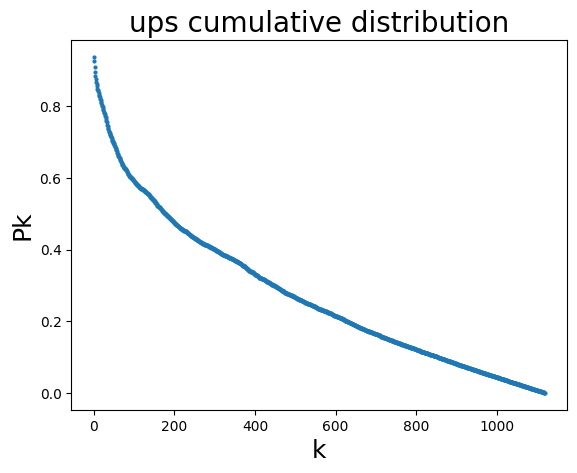

In [23]:
# Plot ups distribution
import numpy as np
ups = np.squeeze(np.array(final_df["ups"]+1))
k = np.unique(ups)
pk = np.histogram(ups,k)[0]
pk = pk/pk.sum()
Pk = 1-np.cumsum(pk)
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(Pk,'o', markersize=2)
plt.title("ups cumulative distribution", size=20)
plt.xlabel("k", size=18)
plt.ylabel("Pk", size=18)
plt.show()

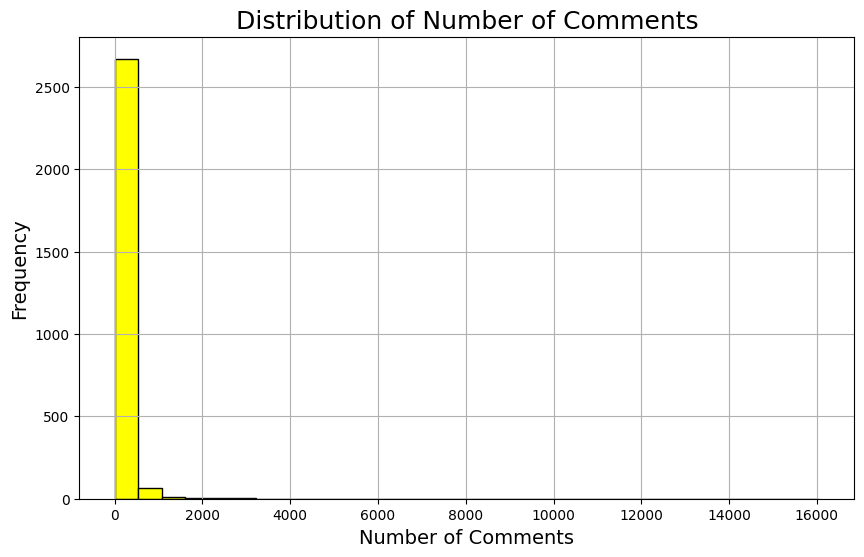

In [24]:
plt.figure(figsize=(10, 6))
plt.hist(final_df["num_comments"], bins=30, color='yellow', edgecolor='black')
plt.title("Distribution of Number of Comments", size=18)
plt.xlabel("Number of Comments", size=14)
plt.ylabel("Frequency", size=14)
plt.grid(True)
plt.show()

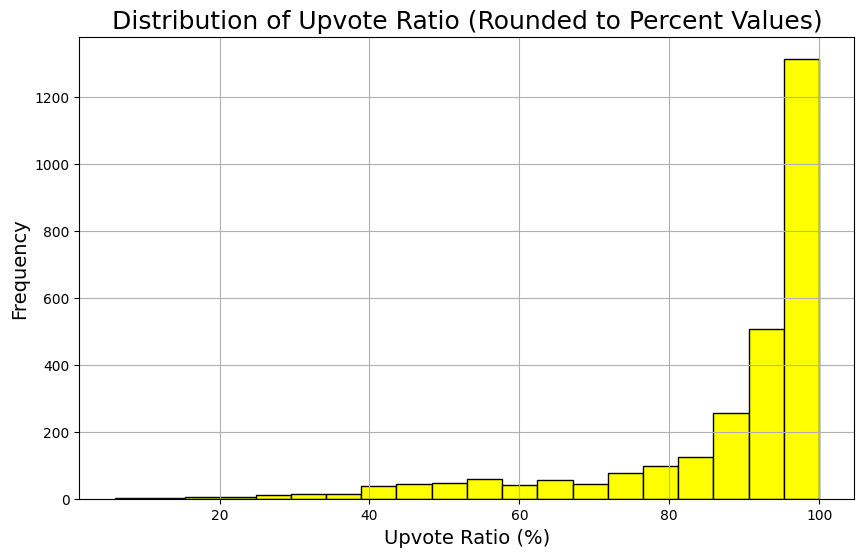

In [25]:
# Rounding upvote ratio to percent values
final_df["upvote_ratio_percent"] = (final_df["upvote_ratio"] * 100).round()

# Plotting the distribution of the rounded upvote ratio
plt.figure(figsize=(10, 6))
plt.hist(final_df["upvote_ratio_percent"], bins=20, color='yellow', edgecolor='black')
plt.title("Distribution of Upvote Ratio (Rounded to Percent Values)", size=18)
plt.xlabel("Upvote Ratio (%)", size=14)
plt.ylabel("Frequency", size=14)
plt.grid(True)
plt.show()

In [26]:
# Filtering the dataframe, keeping the posts that have more than 200 ups
final_df_selected = final_df.copy()
final_df_selected = final_df_selected.loc[final_df_selected['ups'] >=200]
display(final_df_selected)



,id,created,subreddit,title,selftext,author,author_fullname,upvote_ratio,ups,num_comments,upvote_ratio_percent
0,15jrcr4,2023-08-06,movies,'Barbie' Officially Passes $1 Billion Globally...,,MarvelsGrantMan136,t2_5adwlxvn,0.86,40905,3145,86.0
1,15sr5qx,2023-08-16,movies,‘Barbie’ Surpasses ‘The Dark Knight’ as Warner...,,Key_Damage_9220,t2_4nelec8j8,0.87,28764,2388,87.0
2,19cro5j,2024-01-22,movies,The Barbie Movie's Unexpected Message for Men:...,"I know the movie has been out for ages, but he...",Simon_Fokt,t2_ouylczztt,0.82,11124,2348,82.0
3,14p1ufy,2023-07-02,movies,"After “Barbie,” Mattel Is Raiding Its Entire T...",,indig0sixalpha,t2_ht9gq,0.92,8043,1382,92.0
4,174u3a0,2023-10-10,movies,Margot Robbie and Ryan Gosling’s First ‘Barbie...,,indig0sixalpha,t2_ht9gq,0.87,7238,536,87.0
...,...,...,...,...,...,...,...,...,...,...,...
2688,14vu1qr,2023-07-10,CelebEvents,Gal Gadot | ‘Barbie’ World Premiere 9th July 2023,,WiseGuy1882,t2_901nva5i,0.97,216,0,97.0
2689,14y0a2o,2023-07-12,CelebEvents,Margot Robbie | ‘Barbie’ London Premiere 12th ...,,WiseGuy1882,t2_901nva5i,0.99,204,1,99.0
2696,1d408ov,2024-05-30,CelebrityFeetPosts,Margot Robbie,,NowIHaveBecomeBarbie,t2_z3ja51j59,0.99,378,32,99.0
2697,16gf4lb,2023-09-12,CelebrityFeetPosts,Margot Robbie,4K Screencaps from Barbie (2023),Puzzleheaded-Ad-7038,t2_7rv2abhb,0.99,277,10,99.0


In [27]:
# Defining a function to extract comments from a list of post IDs
def extract_comments(post_id_list):

    all_comments = []

    # Loop through each post ID in the provided list
    for i in range(len(post_id_list)):

        try:
            post_id = post_id_list[i]
            submission = reddit.submission(id=post_id)
            submission.comments.replace_more(limit=None)
            collected_comments = list(submission.comments)
            all_comments.extend(collected_comments)
            print(f"Downloaded {len(collected_comments)} comments for post number {i}, id = {post_id}")

        except Exception as error:
            print(f"Rate limit exceeded. Waiting for a moment. Error: {error}")
            time.sleep(7)
            continue

    # Convert the list of comments into a DataFrame
    df = pd.DataFrame(vars(post) for post in all_comments)
    print('a total of ' + str(len(df)) + ' comments have been retrieved')
    return df


In [ ]:
# Extract comments from the selected posts
comments_df = extract_comments(list(final_df_selected['id']))

# Filter the DataFrame to keep only the columns that are useful
comments_df = comments_df[['id','parent_id','created','subreddit','body',
         'author','author_fullname','ups','downs']]

# Convert timestamp to a readable format
comments_df["created"] = [datetime.date.fromtimestamp(i) for i in comments_df["created"]]

# Save the filtered and processed comments DataFrame to a CSV file
comments_df.to_csv('/content/drive/MyDrive/Network_science/reddit2.csv', index=True)

# Display the processed comments DataFrame
display(comments_df)


In [6]:
%run "/content/drive/MyDrive/Network_science/Functions.ipynb"

bertopic 1.11
softlouvain v1.10


In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/Network_science/reddit.csv")
df = df[["id","created","title"]] # we only keep a few meaningful entries
display(df)


# Perform initial cleaning on the title column to remove basic noise
df['text_sup_clean'] = df['title'].apply(superficial_cleaning)

# Perform Deep cleaning
POS_KEEP = ["ADJ","ADV","NOUN","PROPN","VERB","NUM"] # we do not include "PRON"
df['text_deep_clean'] = df['text_sup_clean'].apply(deep_cleaning)
df['text_deep_clean_pos'] = df['text_sup_clean'].apply(deep_cleaning_pos)

# Identify and extract any hashtags from the 'title' column
df['hashtags'] = df['title'].apply(get_hashtags)

# Display the result
display(df)



,id,created,title
0,15jrcr4,2023-08-06,'Barbie' Officially Passes $1 Billion Globally...
1,15sr5qx,2023-08-16,‘Barbie’ Surpasses ‘The Dark Knight’ as Warner...
2,19cro5j,2024-01-22,The Barbie Movie's Unexpected Message for Men:...
3,14p1ufy,2023-07-02,"After “Barbie,” Mattel Is Raiding Its Entire T..."
4,174u3a0,2023-10-10,Margot Robbie and Ryan Gosling’s First ‘Barbie...
...,...,...,...
2917,16snq83,2023-09-26,Barbie mermaid
2918,14mt4hj,2023-06-30,michael cera being allen
2919,15bb1bu,2023-07-27,"Yeah, they’re bad like Barbie 💅"
2920,156sas6,2023-07-22,Several things I can't wrap my head around.


<ipython-input-5-00537011d083>:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(selftext, "html.parser")


,id,created,title,text_sup_clean,text_deep_clean,text_deep_clean_pos,hashtags
0,15jrcr4,2023-08-06,'Barbie' Officially Passes $1 Billion Globally...,barbie officially passes billion globally gre...,barbie officially pass billion globally greta ...,"[barbie NOUN, officially ADV, pass VERB, billi...",[]
1,15sr5qx,2023-08-16,‘Barbie’ Surpasses ‘The Dark Knight’ as Warner...,barbie surpasses the dark knight as warner br...,barbie surpass dark knight warner high gross d...,"[barbie NOUN, surpass VERB, dark ADJ, knight N...",[]
2,19cro5j,2024-01-22,The Barbie Movie's Unexpected Message for Men:...,the barbie movie s unexpected message for men ...,barbie movie unexpected message man challenge ...,"[barbie PROPN, movie NOUN, unexpected ADJ, mes...",[]
3,14p1ufy,2023-07-02,"After “Barbie,” Mattel Is Raiding Its Entire T...",after barbie mattel is raiding its entire toy box,barbie mattel raid entire toy box,"[barbie PROPN, mattel PROPN, raid VERB, entire...",[]
4,174u3a0,2023-10-10,Margot Robbie and Ryan Gosling’s First ‘Barbie...,margot robbie and ryan gosling s first barbie ...,margot robbie ryan gosle barbie reunion ocean ...,"[margot PROPN, robbie PROPN, ryan PROPN, gosle...",[]
...,...,...,...,...,...,...,...
2917,16snq83,2023-09-26,Barbie mermaid,barbie mermaid,barbie mermaid,"[barbie PROPN, mermaid VERB]",[]
2918,14mt4hj,2023-06-30,michael cera being allen,michael cera being allen,michael cera allen,"[michael PROPN, cera PROPN, allen ADJ]",[]
2919,15bb1bu,2023-07-27,"Yeah, they’re bad like Barbie 💅",yeah they are bad like barbie,bad barbie,"[bad ADJ, barbie PROPN]",[]
2920,156sas6,2023-07-22,Several things I can't wrap my head around.,several things i cannot wrap my head around,thing wrap head,"[several ADJ, thing NOUN, wrap VERB, head NOUN...",[]


In [ ]:
mask = '2023-07-21'

df_after = df[df['created']>=mask]
df_after = df_after.reset_index()

In [ ]:
out_dir = "/content/drive/MyDrive/Network_science/"
out_file = "final_barbie_reddit_"

df_after.to_excel(out_dir+out_file+"after_cleaned.xlsx", index=True)

In [ ]:
# Create a unique collection of words
words_after = np.unique([item for sublist in df_after['text_deep_clean_pos'] for item in sublist])
# Create a dictionary where each unique word is mapped to a unique integer.
words_dict_after = dict(zip(words_after,range(len(words_after))))
# Initialize an occurrence matrix
Mwd_after = csr_matrix((len(words_dict_after), len(df_after)), dtype = np.int8).toarray()
for i in range(len(df_after)):
  for j in df_after['text_deep_clean_pos'][i]:
    Mwd_after[words_dict_after[j],i] += 1


In [ ]:
# Collect a unique set of hashtags from the 'hashtags' column
hashtags_after = np.unique([item for sublist in df_after['hashtags'] for item in sublist])
# Prepend the hash (#) symbol to each hashtag
hashtags2_after = np.unique(["#"+item for sublist in df_after['hashtags'] for item in sublist])
# Create a dictionary mapping each unique hashtag to a unique integer
hashtags_dict_after = dict(zip(hashtags_after,range(len(hashtags_after))))
# Initialize an occurrence matrix
Mhd_after = csr_matrix((len(hashtags_dict_after), len(df_after)), dtype = np.int8).toarray()
for i in range(len(df_after)):
  for j in df_after['hashtags'][i]:
    Mhd_after[hashtags_dict_after[j],i] += 1

In [ ]:
# Combine words and hashtags
Mwd_after = np.vstack((Mwd_after, Mhd_after))
words_after = np.hstack((words_after, hashtags2_after))
documents_after = np.array(df_after["id"].tolist())

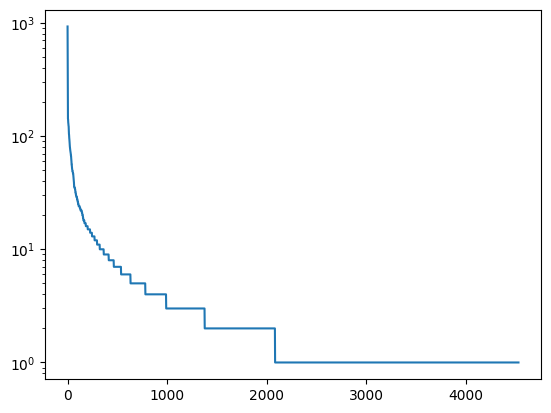

In [ ]:
plt.figure()
plt.semilogy(-np.sort(-np.sum(Mwd_after,axis=1)))
plt.savefig(out_dir+out_file+"_statistics_after.png")


In [ ]:
# Filter out words with low occurrence
select_after = (np.sum(Mwd_after,axis=1)>2)
Mwd_after = Mwd_after[select_after,:]
words_after = words_after[select_after]
# Filter out documents that do not contain words
select_after = (np.sum(Mwd_after,axis=0)>0)
Mwd_after = Mwd_after[:,select_after]
documents_after = documents_after[select_after]
# Display the shape of the final word occurrence matrix after filtering
display(Mwd_after.shape)

(1377, 2369)

In [ ]:
# Save the result
pickle.dump([Mwd_after,words_after,documents_after], open(out_dir+out_file+"after_occurrences.p", "wb"))
# c,d,e = pickle.load(open(out_dir+out_file+"_occurrences.p","rb"))


In [ ]:
c,d,e = pickle.load(open("/content/drive/MyDrive/Network_science/final_barbie_reddit_after_occurrences.p","rb"))


In [ ]:
e

array(['15jrcr4', '15sr5qx', '19cro5j', ..., '15bb1bu', '156sas6',
       '157272i'], dtype='<U7')

In [1]:
!pip install bertopic
from bertopic import BERTopic

In [7]:
in_dir = "/content/drive/MyDrive/Network_science/"
in_file = "final_barbie_reddit_after"

# Load the serialized word occurrence data
Mwd, words, documents = pickle.load(open(in_dir+in_file+"_occurrences.p","rb"))
Mwd = sps.csr_matrix(Mwd)

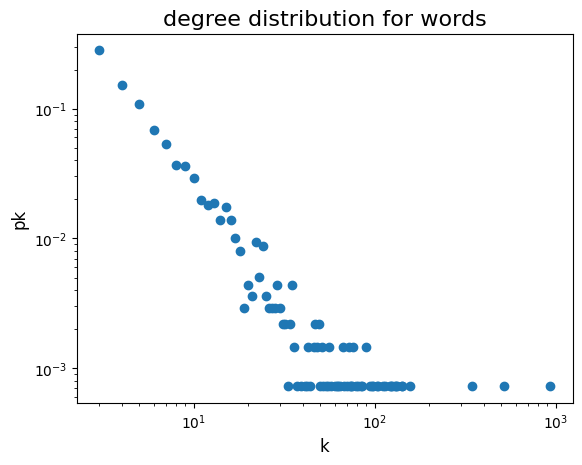

In [8]:
# Calculate the degree distribution for words within the word occurrence matrix
dw = np.squeeze(np.asarray(Mwd.sum(axis=1))) # words degrees
k = np.unique(dw)
pk = np.histogram(dw,np.append(k,k[-1]+1))[0]
pk = pk/pk.sum()
Pk = 1-np.cumsum(pk)
fig = plt.figure()
plt.loglog(k,pk,'o')
plt.title("degree distribution for words", size=16)
plt.xlabel("k", size=12)
plt.ylabel("pk", size=12)
plt.show()



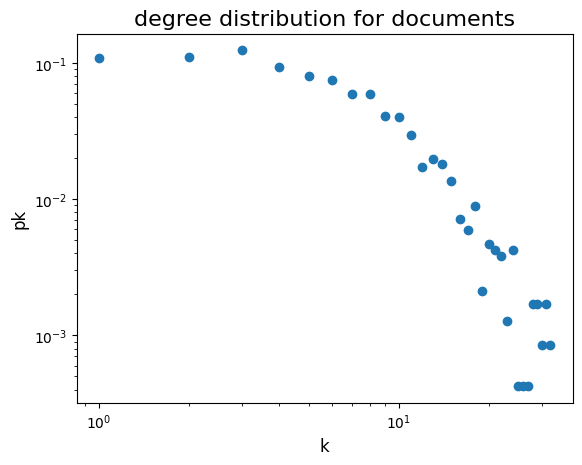

In [9]:
dd = np.squeeze(np.asarray(Mwd.sum(axis=0))) # documents degrees
k = np.unique(dd)
pk = np.histogram(dd,np.append(k,k[-1]+1))[0]
pk = pk/pk.sum()
Pk = 1-np.cumsum(pk)
fig = plt.figure()
plt.loglog(pk,'o')
plt.title("degree distribution for documents", size=16)
plt.xlabel("k", size=12)
plt.ylabel("pk", size=12)
plt.show()

In [10]:
# Remove elements that are excessively central
Mwd, words, documents = clean_Mwd_matrix(Mwd,words,documents)

removing: barbie PROPN break NOUN museum NOUN 


In [11]:
# Construct probability matrices
Pwd, Pww, Pdd, Paa = probability_matrices(Mwd, tform=False)

In [12]:
# Start a timer to measure the execution time
tic = time.time()

# Generate a graph from the document-document probability matrix
A = sps.csr_matrix(Pdd)
G = ig.Graph.Adjacency((A > 0).toarray().tolist())
G.es['weight'] = np.array(A[A.nonzero()])[0]

# Apply the Louvain algorithm to the graph for community detection
part = louvain.find_partition(G, louvain.ModularityVertexPartition,
                                 weights='weight')

# Define a function to convert the Louvain partitioning result into a community assignment matrix (C)
def partition_to_C(part):
  C = sps.csr_matrix((Pdd.shape[0],len(part)))
  for i in range(len(part)):
    C[np.array(part[i]),i] = 1
  return C

# Convert the Louvain partition into a community assignment matrix
C_l = partition_to_C(part)

# Record the time taken to perform the initial Louvain
et_louv = time.time()-tic

# Apply a refinement step with a 'soft' Louvain algorithm variant
C_sl, _, _ = my_soft_louvain(Pdd, C_l)

# Record the total execution time
et_slouv = time.time()-tic

/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


[2148, 2148]
272.94321753800835
82.02438661763944
26.870057685088817
12.727922061357859
4.242640687119286
7.0710678118654755
8.485281374238571
4.242640687119286
4.242640687119286
0.0
[2148, 25]
11.313708498984763
0.0
[2148, 21]
0.0


In [13]:
# Load the cleaned text data
df2 = pd.read_excel(in_dir+in_file+"_cleaned.xlsx")
df2["id"] = np.array([str(i) for i in df2["id"]])

# Filter 'df2' to include only those documents that are present in the community assignment matrix 'Pcc'
documents = np.array([str(i) for i in documents])
df2 = df2.loc[df2['id'].isin(documents)]
df2.index = np.array(range(len(df2)))

# Reinsert hashtags into the cleaned text
df2["text_deep_clean2"] = [str(df2["text_deep_clean"][i]) + " #" +
                           df2["hashtags"][i][2:-2].replace("', '"," #")
                           for i in range(len(df2))]

In [14]:
# Start a timer to measure the execution time for topic modeling with BERTopic
tic = time.time()

# Initialize a BERTopic instance for topic modeling
bert_model = BERTopic()

# Perform topic modeling on the documents using BERTopic
docs = list(df2["title"])
topics, probabilities = bert_model.fit_transform(docs)

# Define a function to convert the topic assignments into a community assignment matrix
def topics_to_C(topics):
  # extract community assignments
  C = sps.csr_matrix((len(topics),max(topics)+2))
  for i in range(C.shape[1]):
    C[np.array(topics)==(i-1),i] = 1
  # remove zero assignments
  C = C[:,np.unique(scipy.sparse.find(C)[1])]
  return C

# Convert the list of topic assignments into a community assignment
C_b = topics_to_C(topics)

# Calculate and capture the execution time
et_bert = time.time()-tic


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [15]:
# Initialize a DataFrame
df = pd.DataFrame(data={'data':[],'algo':[],'time':[],'c#':[],
                        'NMI':[],'Q':[],'Ncut':[],'InfoMap':[]})

# Compute the Infomap ranking vector 'r'
r = infomap_rank(Pdd)

In [16]:
# Evaluate clustering performance metrics for the hard Louvain method
stats = clustering_statistics(C_l,Pwd,Pdd,r)
# Store them into the dataframe
df.loc[len(df)] = [in_file,"hard Louvain Pdd",et_louv,C_l.shape[1]] + stats

# Evaluate clustering performance metrics for the soft Louvain method
stats = clustering_statistics(C_sl,Pwd,Pdd,r)
# Store them into the dataframe
df.loc[len(df)] = [in_file,"soft Louvain Pdd",et_slouv,C_sl.shape[1]] + stats

# Evaluate clustering performance metrics for the hard BERTopic method
stats = clustering_statistics(C_b,Pwd,Pdd,r)
# Store them into the dataframe
df.loc[len(df)] = [in_file,"BERTopic",et_bert,C_b.shape[1]] + stats

/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [17]:
# Display the result
display(df)

,data,algo,time,c#,NMI,Q,Ncut,InfoMap
0,final_barbie_reddit_after,hard Louvain Pdd,3.665763,25,0.567845,0.410456,0.517204,-0.019771
1,final_barbie_reddit_after,soft Louvain Pdd,27.743295,21,0.562239,0.412143,0.501047,-0.016621
2,final_barbie_reddit_after,BERTopic,66.522342,42,0.513151,0.256547,0.692836,0.032926


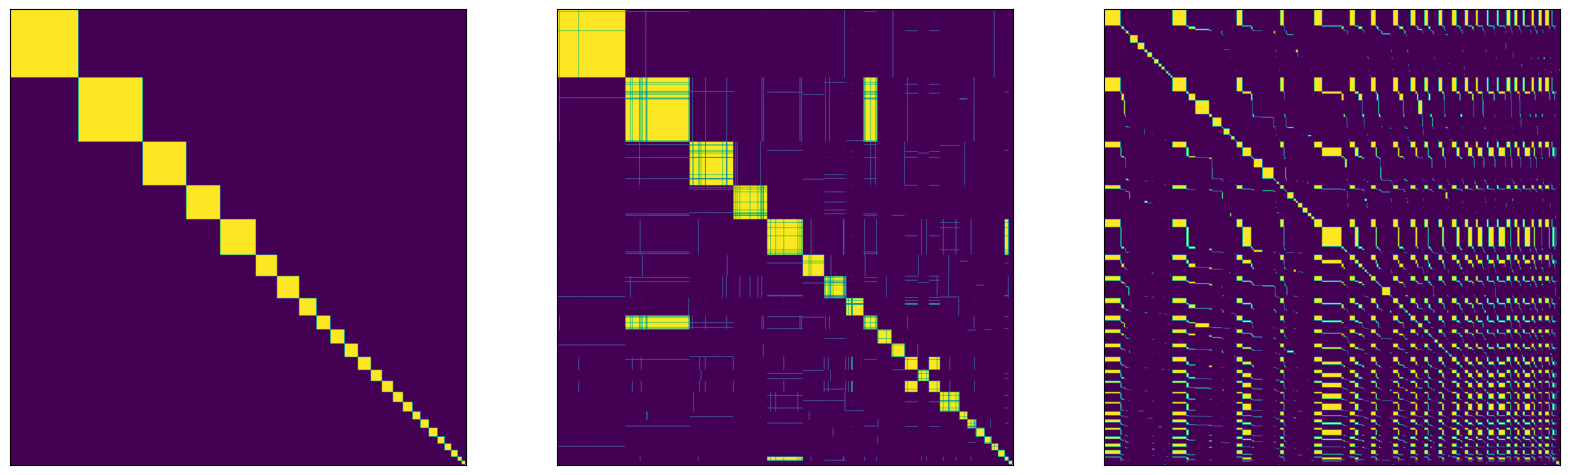

In [ ]:
# #  Visualize the community structures
plot_community_patterns([C_l,C_sl,C_b],nrows=1,ncols=3,refs=[0,2])


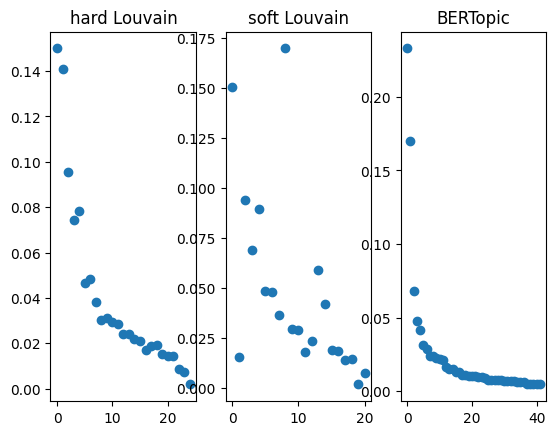

In [ ]:
# visualizes the distribution of documents across communities
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.plot(np.array(C_l.sum(axis=0))[0]/C_l.sum(),'o')
ax1.set_title('hard Louvain')
ax2.plot(np.array(C_sl.sum(axis=0))[0]/C_sl.sum(),'o')
ax2.set_title('soft Louvain')
ax3.plot(np.array(C_b.sum(axis=0))[0]/C_b.sum(),'o')
ax3.set_title('BERTopic');


In [ ]:
# Initialize a BERTopic model customized for the communities identified by Louvain
docs = list(df2["text_deep_clean2"])
bert_model1 = bertopic_overwrite(bert_model,docs,C_l)

# Visualize the top words for each topic (community) identified
bert_model1.visualize_barchart(topics = range(C_l.shape[1]),
                               n_words = 8,
                               title = "Louvain results")


In [ ]:
# BERTopic second

# use the clean text in order to get a more meaningful description
docs = list(df2["text_deep_clean2"])
bert_model2 = bertopic_overwrite(bert_model,docs,C_b)

# visualize topic description
bert_model2.visualize_barchart(topics = range(C_b.shape[1]),
                               n_words = 8,
                               title = "BERTopic results")

In [ ]:
topics = bert_model1.get_topics()
print(topics)

{0: [('office', 0.06579275717910729), ('box', 0.0637793159987106), ('million', 0.05121998724034276), ('weekend', 0.04606673258738782), ('gross', 0.04389468482795383), ('big', 0.0409503946302246), ('oppenheimer', 0.037875418852704006), ('domestic', 0.03742154662144511), ('global', 0.032707491075359515), ('warner', 0.032483035482759486)], 1: [('good', 0.06994207286454271), ('oscar', 0.065133929973375), ('award', 0.06479548398500821), ('picture', 0.0558026364006688), ('winner', 0.04356313836735383), ('prediction', 0.04286101302275423), ('film', 0.04124537411810516), ('nomination', 0.03995577889388109), ('globe', 0.03790090826981066), ('golden', 0.03544707887678665)], 2: [('ken', 0.09585363136040441), ('ryan', 0.0803155398694453), ('play', 0.05528646146198196), ('gosling', 0.05457264200234559), ('gosle', 0.050117527504045384), ('barbie', 0.04179575604832338), ('real', 0.03227775174106877), ('feel', 0.02701505627872401), ('weird', 0.024575247591273938), ('want', 0.024250520555492393)], 3: [

In [ ]:


topics = bert_model1.get_topics()
new_df = pd.DataFrame.from_dict(topics, orient='index')

ktopics = []

for topic_list in range(0, new_df.shape[1]):
  for topic in range(0, new_df.shape[0]):
      ktopics.append(new_df[topic_list][topic][0])

unique_ktopics  = set(ktopics)
topics_ktopics = list(unique_ktopics)

In [ ]:
# Load the CSV file
df = pd.read_excel("/content/drive/MyDrive/Network_science/final_barbie_reddit_after_cleaned.xlsx")

# Extract all keywords from the BERT model's output
keywords = topics_ktopics

df["hashtags_2"] = None
for i in range(len(df["text_deep_clean"])):
  if isinstance(df["text_deep_clean"][i], str):  # Check if text is a string
    hashtags2 = []

    for word in df["text_deep_clean"][i].split():

      if word in keywords:
        #  print(type(word))
          hashtags2.append(str(word))
          df["hashtags_2"][i] = hashtags2

In [ ]:
df.to_pickle('/content/drive/MyDrive/Network_science/final_barbie_reddit_after_cleaned.pkl')

In [ ]:
comments_df = pd.read_pickle("/content/drive/MyDrive/Network_science/final_barbie_reddit_after_cleaned.pkl")


In [ ]:
comments_filtered = comments_df.copy()
column_list = ["id","created", "text_deep_clean", "text_deep_clean_pos", "hashtags_2"]
comments_filtered = comments_filtered[column_list]

In [ ]:
#initialize an empty dict
unique_words = {}
for row in comments_filtered["text_deep_clean"]:
    if pd.notna(row):
        # Split the row into words and iterate over them
        for word in row.split(" "):
            #if the word is encountered for the first time add to dict as key and set its value to 0
            unique_words.setdefault(word,0)
            #increase the value (i.e the count) of the word by 1 every time it is encountered
            unique_words[word] += 1


In [ ]:
uw_df = pd.DataFrame.from_dict(unique_words, orient='index').reset_index()
uw_df.rename(columns = {'index':'Word', 0:'Count'}, inplace=True)
uw_df.sort_values(by=['Count'], ascending=False, inplace=True)
uw_df

,Word,Count
0,barbie,1579
20,movie,358
389,m,274
39,oppenheimer,174
56,film,157
...,...,...
2091,barely,1
2089,weekday,1
2087,climb,1
2086,vs,1


In [ ]:
!pip install wordcloud matplotlib
from wordcloud import WordCloud

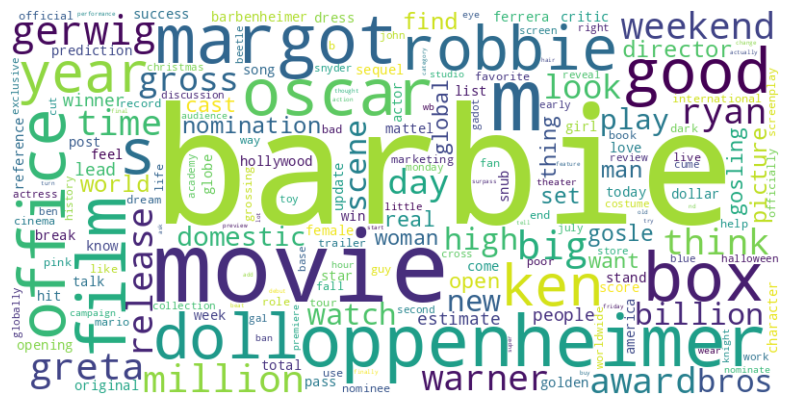

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(uw_df.set_index('Word').to_dict()['Count'])
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
unique_hashtags = {}


for idx, row in comments_filtered.iterrows():
  hashtag_list = []
  try:
    for hashtag in row["hashtags_2"]:
      unique_hashtags.setdefault("#"+hashtag, 0)
      unique_hashtags['#'+hashtag] += 1
      hashtag_list.append(hashtag)
  except:
      continue

In [ ]:
uh_df = pd.DataFrame.from_dict(unique_hashtags, orient='index').reset_index()
uh_df.rename(columns = {'index':'Hashtag', 0:'Count'}, inplace=True)
uh_df.sort_values(by=['Count'], ascending=False, inplace=True)

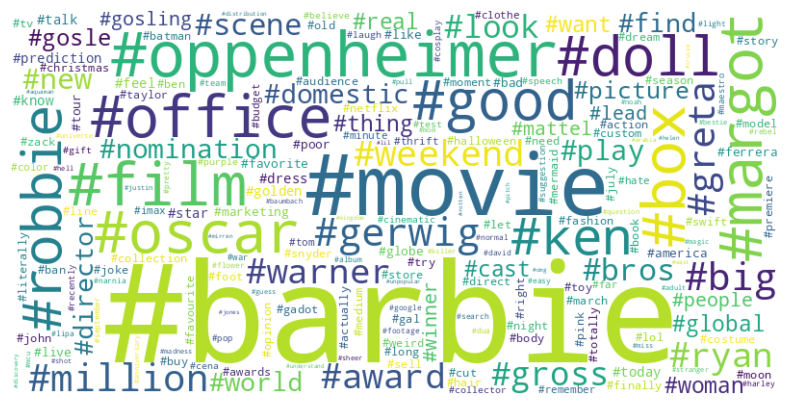

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(uh_df.set_index('Hashtag').to_dict()['Count'])
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
import itertools
import networkx as nx

In [ ]:
uh = unique_hashtags.keys()
uw = unique_words.keys()

In [ ]:
import numpy as np
network = {}
for index, row in comments_filtered.iterrows():
    combined_list = row['hashtags_2']  # Use keys() to get the list of unique subreddits
    if isinstance(combined_list, list):
      for pair in itertools.product(combined_list, combined_list):
          if pair[0] != pair[1] and not (pair[::-1] in network):
              #breakpoint()
              network.setdefault(pair, 0)
              # Update the weight based on actual occurrences
              network[pair] += 1

network_df = pd.DataFrame.from_dict(network, orient="index")

In [ ]:
network_df.reset_index(inplace=True)
network_df.columns = ["pair","weight"]
network_df.sort_values(by="weight",inplace=True, ascending=False)
network_df

,pair,weight
12,"(barbie, movie)",246
30,"(barbie, oppenheimer)",167
386,"(box, office)",153
540,"(barbie, box)",147
18,"(margot, barbie)",146
...,...,...
1762,"(like, war)",1
1758,"(know, war)",1
1755,"(long, cast)",1
1754,"(look, pull)",1


In [ ]:
#to get weighted graph we need a list of 3-element tuplels (u,v,w) where u and v are nodes and w is a number representing weight
up_weighted = []
for edge in network:
    #we can filter edges by weight by uncommenting the next line and setting desired weight threshold
    #if(network[edge])>1:
    up_weighted.append((edge[0],edge[1],network[edge]))

G = nx.Graph()
G.add_weighted_edges_from(up_weighted)

In [ ]:
print(len(G.nodes()))
print(len(G.edges()))

232
2968


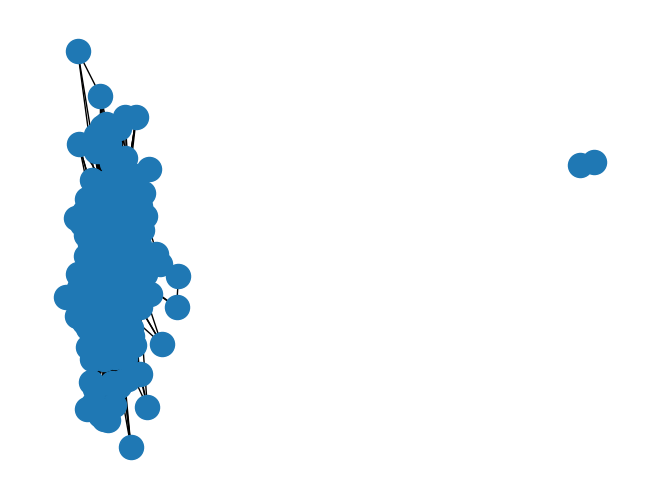

In [ ]:
nx.draw(G)

In [ ]:
filename = "/content/drive/MyDrive/Network_science/barbie_edgelist_after_released.csv"

In [ ]:
nx.write_weighted_edgelist(G, filename, delimiter=",")

In [ ]:
word_nodes = pd.DataFrame.from_dict(unique_words,orient="index")
word_nodes.reset_index(inplace=True)
word_nodes["Label"] = word_nodes["index"]
word_nodes.rename(columns={"index":"Id",0:"delete"},inplace=True)
word_nodes = word_nodes.drop(columns=['delete'])

In [ ]:
hashtag_nodes = uh_df.copy()
hashtag_nodes["Label"] = hashtag_nodes["Hashtag"]
hashtag_nodes.rename(columns={"Hashtag":"Id"},inplace=True)
hashtag_nodes = hashtag_nodes.drop(columns=['Count'])

In [ ]:


nodelist = hashtag_nodes
nodelist.to_csv("/content/drive/MyDrive/Network_science/barbie_nodelist_after_released.csv",index=False)



In [ ]:


a = pd.read_csv("/content/drive/MyDrive/Network_science/barbie_edgelist_after_released.csv")



In [ ]:


a.columns = ['Source','Target','Label']



In [ ]:
a.to_csv("/content/drive/MyDrive/Network_science/barbie_edgelist_after_released.csv",index=False)
